# Exploring data and features

## Core Features that could be added:

### Price-Based Features:

- Returns: 1-day, 3-day, 5-day, 10-day returns
- Price ratios: Current price / MA(5), Current price / MA(20)
- Gap features: (Open - Previous Close) / Previous Close
- Intraday range: (High - Low) / Close

### Volume Features:

- Volume ratios: Current volume / MA(20 volume)
- Price-volume: Return * Volume (captures momentum with conviction)

### Technical Indicators:

- RSI (14-day) - momentum oscillator
- MACD signal (12,26,9) - trend following
- Bollinger Band position: (Price - BB_lower) / (BB_upper - BB_lower)

### Market Context:

- VIX level (fear index)
- Sector/market performance: Stock return vs S&P 500 return
- Day of week dummy variables

### Target Variable:

- Binary: 1 if next day's close > today's close, 0 otherwise

# Load csv data

In [ ]:
import pandas as pd

data = pd.read_csv("../data/interim/data_with_target.csv", index_col=0)


In [247]:
data

,Date,Ticker,Close,High,Low,Open,Volume,WTI_Oil,US10Y,VIX,DJI,GSPC,NDX,RUT,Target
0,2020-01-02,AAPL,72.538513,72.598892,71.292304,71.545890,135480400,61.180000,1.882,12.47,28868.800781,3257.850098,8872.219727,1666.770020,0
1,2020-01-02,AMZN,94.900497,94.900497,93.207497,93.750000,80580000,61.180000,1.882,12.47,28868.800781,3257.850098,8872.219727,1666.770020,0
2,2020-01-02,BA,331.348572,331.378393,325.761816,326.606765,4544400,61.180000,1.882,12.47,28868.800781,3257.850098,8872.219727,1666.770020,1
3,2020-01-02,BAC,30.920326,30.937678,30.616677,30.668729,37614200,61.180000,1.882,12.47,28868.800781,3257.850098,8872.219727,1666.770020,0
4,2020-01-02,BHP,33.608608,33.822793,33.522936,33.792196,1382193,61.180000,1.882,12.47,28868.800781,3257.850098,8872.219727,1666.770020,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28929,2024-12-31,T,22.028353,22.105747,21.863890,21.883239,22342800,71.720001,4.573,17.35,42544.218750,5881.629883,21012.169922,2230.159912,1
28930,2024-12-31,VTI,287.925415,290.240280,287.190237,289.912409,3893200,71.720001,4.573,17.35,42544.218750,5881.629883,21012.169922,2230.159912,1
28931,2024-12-31,XOM,104.669357,104.990461,102.927624,103.307107,12387800,71.720001,4.573,17.35,42544.218750,5881.629883,21012.169922,2230.159912,1
28932,2024-12-31,^TNX,4.573000,4.587000,4.521000,4.529000,0,71.720001,4.573,17.35,42544.218750,5881.629883,21012.169922,2230.159912,1


# Add features
Doing this before one-hot encoding stocks will make it easier for calculations

In [320]:
macro_tickers = ['VIX', 'WTI_Oil', 'US10Y']  # VIX, WTI Oil, 10Y Treasury

data['VIX_ret'] = data['VIX'].pct_change()
data['WTI_ret'] = data['WTI_Oil'].pct_change()
data['TNX_ret'] = data['US10Y'].pct_change()

data['VIX_5d_mean'] = data['VIX'].rolling(5).mean()
data['WTI_5d_std'] = data['WTI_Oil'].rolling(5).std()

In [321]:
market_indices = ["GSPC", "NDX", "RUT", "DJI"]

for idx in market_indices:
    data[f'{idx}_return_1d'] = data[idx].pct_change()
    data[f'{idx}_return_5d'] = data[idx].pct_change(5)

In [322]:
import talib

data['return_1d'] = data.groupby('Ticker')['Close'].pct_change()
data['return_3d'] = data.groupby('Ticker')['Close'].pct_change(3)
data['return_5d'] = data.groupby('Ticker')['Close'].pct_change(5)
data['return_10d'] = data.groupby('Ticker')['Close'].pct_change(10)

data['ma_5'] = data.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=5).mean())
data['ma_20'] = data.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=20).mean())

data['price_ma5_ratio'] = data['Close'] / data['ma_5']
data['price_ma20_ratio'] = data['Close'] / data['ma_20']

data['volume_ratio'] = (
    data['Volume'] / 
    data.groupby('Ticker')['Volume'].transform(lambda x: x.rolling(20).mean())
)

data['price_volume'] = data['return_1d'] * data['Volume']

data['rsi'] = data.groupby('Ticker')['Close'].transform(
    lambda x: talib.RSI(x.values, timeperiod=14)
)

data['macd'] = data.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=12, adjust=False).mean() - x.ewm(span=26, adjust=False).mean())
data['macd_signal'] = data.groupby('Ticker')['macd'].transform(lambda x: x.ewm(span=9, adjust=False).mean())
data['macd_hist'] = data['macd'] - data['macd_signal'] 

In [206]:
data

,Date,Ticker,Close,High,Low,Open,Volume,Close_WTI_Oil,Close_US10Y,Close_VIX,...,ma_5,ma_20,price_ma5_ratio,price_ma20_ratio,volume_ratio,price_volume,rsi,macd,macd_signal,macd_hist
0,2020-01-02,AAPL,72.538513,72.598892,71.292304,71.545890,135480400,61.180000,1.882,12.47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
1,2020-01-02,AMZN,94.900497,94.900497,93.207497,93.750000,80580000,61.180000,1.882,12.47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
2,2020-01-02,BA,331.348572,331.378393,325.761816,326.606765,4544400,61.180000,1.882,12.47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
3,2020-01-02,BAC,30.920328,30.937680,30.616679,30.668731,37614200,61.180000,1.882,12.47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
4,2020-01-02,BHP,33.608612,33.822797,33.522940,33.792200,1382193,61.180000,1.882,12.47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28929,2024-12-31,T,22.028353,22.105747,21.863890,21.883239,22342800,71.720001,4.573,17.35,...,22.086399,22.385818,0.997372,0.984032,0.615997,158107.574053,47.674542,-0.020294,0.055084,-0.075379
28930,2024-12-31,VTI,287.925415,290.240280,287.190237,289.912409,3893200,71.720001,4.573,17.35,...,291.911316,294.711401,0.986346,0.976974,1.229428,-13520.654188,40.698731,-0.552695,0.457792,-1.010487
28931,2024-12-31,XOM,104.669365,104.990468,102.927632,103.307115,12387800,71.720001,4.573,17.35,...,103.667140,106.728794,1.009668,0.980704,0.723517,212006.506014,34.801201,-2.795823,-2.806249,0.010427
28932,2024-12-31,^TNX,4.573000,4.587000,4.521000,4.529000,0,71.720001,4.573,17.35,...,4.581400,4.401200,0.998166,1.039035,NaN,0.000000,63.362347,0.086270,0.070208,0.016062


In [323]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encode stock symbols (will need to normalize features within each stock 
# to account for different scales instead when adding more stocks to dataset)

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_values = encoder.fit_transform(data[['Ticker']])
new_cols = encoder.get_feature_names_out(['Ticker'])

df_encoded = pd.DataFrame(encoded_values, columns=new_cols, index=data.index)

df = pd.concat(
    [data.drop(columns=['Ticker']), df_encoded],
    axis=1
)

In [208]:
df

,Date,Close,High,Low,Open,Volume,Close_WTI_Oil,Close_US10Y,Close_VIX,Target,...,Ticker_NEE,Ticker_NVDA,Ticker_PFE,Ticker_QQQ,Ticker_SPY,Ticker_T,Ticker_VTI,Ticker_XOM,Ticker_^TNX,Ticker_^VIX
0,2020-01-02,72.538513,72.598892,71.292304,71.545890,135480400,61.180000,1.882,12.47,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-02,94.900497,94.900497,93.207497,93.750000,80580000,61.180000,1.882,12.47,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-02,331.348572,331.378393,325.761816,326.606765,4544400,61.180000,1.882,12.47,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-02,30.920328,30.937680,30.616679,30.668731,37614200,61.180000,1.882,12.47,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-02,33.608612,33.822797,33.522940,33.792200,1382193,61.180000,1.882,12.47,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28929,2024-12-31,22.028353,22.105747,21.863890,21.883239,22342800,71.720001,4.573,17.35,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
28930,2024-12-31,287.925415,290.240280,287.190237,289.912409,3893200,71.720001,4.573,17.35,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
28931,2024-12-31,104.669365,104.990468,102.927632,103.307115,12387800,71.720001,4.573,17.35,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
28932,2024-12-31,4.573000,4.587000,4.521000,4.529000,0,71.720001,4.573,17.35,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Handle NaNs

XGBoost can handle NaNs in features, except in the target variable. For now I will drop them anyway.

In [308]:
df = df.dropna()

# Split training/test data

In [ ]:
from sklearn.model_selection import train_test_split

tickers = ["AAPL", "MSFT", "GOOG", "AMZN", "NVDA", "JPM", "BAC", "JNJ", "PFE", "DIS", "KO", "BA", "XOM", "BHP", "NEE", "T", "SPY", "QQQ", "IWM", "VTI"]
ticker_columns = [col for col in df.columns if col.startswith('Ticker_')]
macro_features = ['VIX_ret', 'WTI_ret', 'TNX_ret', 'VIX_5d_mean', 'WTI_5d_std'] 
feature_columns = ['return_1d', 'return_3d', 'return_5d', 'volume_ratio', 'rsi', 'macd', 'macd_hist', 'price_ma5_ratio', 'price_ma20_ratio', 'price_volume'] + ticker_columns + macro_features

X = df[feature_columns]
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Check for class imbalances

In [310]:
print("\nTraining set class distribution:")
train_counts = y_train.value_counts(normalize=True)
print(f"Class -1: {train_counts.get(0, 0):.1%}, "
      f"Class 0: {train_counts.get(1, 0):.1%}, "
      f"Class 1: {train_counts.get(2, 0):.1%}")

print("\nTest set class distribution:")
test_counts = y_test.value_counts(normalize=True)
print(f"Class -1: {test_counts.get(0, 0):.1%}, "
      f"Class 0: {test_counts.get(1, 0):.1%}, "
      f"Class 1: {test_counts.get(2, 0):.1%}")


Training set class distribution:
Class -1: 43.6%, Class 0: 6.1%, Class 1: 50.3%

Test set class distribution:
Class -1: 39.8%, Class 0: 9.1%, Class 1: 51.2%


## Calculate class weight

In [311]:
import numpy as np

class_counts = y_train.value_counts().to_dict()
n_total = len(y_train)
n_classes = len(class_counts)

# Compute weights
class_weights = {cls: n_total / (count * n_classes) for cls, count in class_counts.items()}
print("Class weights:", class_weights)


Class weights: {2: 0.662623754496546, 0: 0.7647231713141556, 1: 5.4589562024652505}


# Train model

## Hyperparameter tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import uniform, randint
from xgboost import XGBClassifier

xgb = XGBClassifier(
    eval_metric='logloss',
    random_state=42
)

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.5, 1.0]
}

# Need TimeSeriesSplit for financial data
tscv = TimeSeriesSplit(n_splits=3)

random_search = RandomizedSearchCV(
    xgb, 
    param_distributions=param_dist,
    n_iter=30,
    scoring='balanced_accuracy',
    cv=tscv,
    verbose=1, 
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best params:", random_search.best_params_)
print("Best score:", random_search.best_score_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


c:\Users\maria\stock-movement-prediction-ml\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:49:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'subsample': 0.9, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.15, 'colsample_bytree': 0.9}
Best score: 0.3401963405283206


## Feature selection based on performance

In [318]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer, balanced_accuracy_score

base_features = feature_columns
candidate_feature_sets =  [[], ['VIX_5d_mean', 'WTI_5d_std']]

for ft in candidate_feature_sets:
    model = XGBClassifier(
        eval_metric='logloss',
        random_state=42,

        # Obtained from hyperparameter tuning
        subsample=0.9,
        reg_lambda=1.0,
        reg_alpha=0,
        n_estimators=100,
        min_child_weight=5,
        max_depth=4,
        learning_rate=0.05,
        colsample_bytree=0.8
    )

    X1 = df[base_features + ft]
    y1 = df['Target']

    X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, shuffle=False)

    weights = y1_train.map(class_weights)

    model.fit(X1_train, y1_train, sample_weight=weights)

    y1_pred = model.predict(X1_test)

    tscv = TimeSeriesSplit(n_splits=3)
    scores = cross_val_score(model, X1, y1, cv=tscv,
                                scoring=make_scorer(balanced_accuracy_score))
    print('Added features: ' + str(ft))
    print('Balanced CV Accuracy:', scores.mean())

Added features: []
Balanced CV Accuracy: 0.3346686596088467
Added features: ['VIX_5d_mean', 'WTI_5d_std']
Balanced CV Accuracy: 0.3373701979486956


In [312]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.metrics import make_scorer, balanced_accuracy_score

model = XGBClassifier(
    eval_metric='logloss',
    random_state=42,

    # Obtained from hyperparameter tuning
    subsample=0.9,
    reg_lambda=1.0,
    reg_alpha=0,
    n_estimators=100,
    min_child_weight=5,
    max_depth=4,
    learning_rate=0.05,
    colsample_bytree=0.8
)

weights = y_train.map(class_weights)

# Train the model
model.fit(X_train, y_train, sample_weight=weights)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for positive class

## Evaluate performance

In [313]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

# Basic accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Balanced CV Accuracy
tscv = TimeSeriesSplit(n_splits=3)
scores = cross_val_score(
    model, X, y, cv=tscv, scoring=make_scorer(balanced_accuracy_score)
)
print(f"Balanced CV Accuracy: {scores.mean():.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Down", "Flat", "Up"]))

# Confusion Matrix with labels
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
print("          Pred Down   Pred Flat   Pred Up")
print(f"Actual Down   {cm[0,0]:>5}        {cm[0,1]:>5}      {cm[0,2]:>5}")
print(f"Actual Flat   {cm[1,0]:>5}        {cm[1,1]:>5}      {cm[1,2]:>5}")
print(f"Actual Up     {cm[2,0]:>5}        {cm[2,1]:>5}      {cm[2,2]:>5}")


Accuracy: 0.2652
Balanced CV Accuracy: 0.3347

Classification Report:
              precision    recall  f1-score   support

        Down       0.41      0.25      0.31      2071
        Flat       0.10      0.59      0.17       471
          Up       0.52      0.22      0.31      2662

    accuracy                           0.27      5204
   macro avg       0.34      0.35      0.26      5204
weighted avg       0.44      0.27      0.30      5204


Confusion Matrix:
          Pred Down   Pred Flat   Pred Up
Actual Down     518         1092        461
Actual Flat     108          278         85
Actual Up       646         1432        584


## Feature correlation

Return feature correlations:
           return_1d  return_3d  return_5d
return_1d   1.000000   0.649080   0.522679
return_3d   0.649080   1.000000   0.769008
return_5d   0.522679   0.769008   1.000000


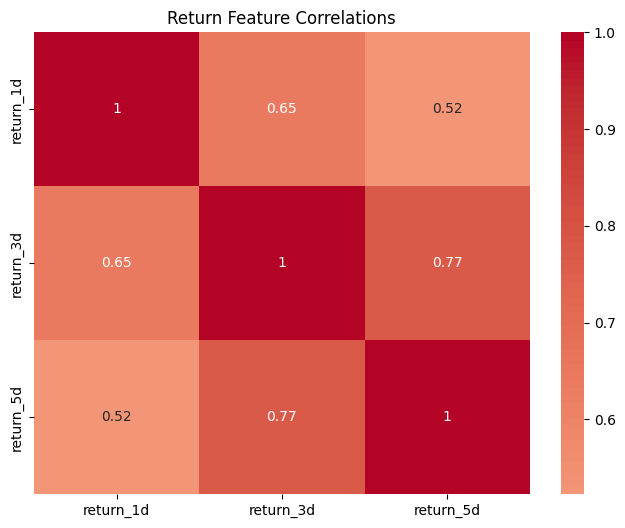

In [324]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check correlation between your return features
return_features = ['return_1d', 'return_3d', 'return_5d']
correlation_matrix = X_train[return_features].corr()

print("Return feature correlations:")
print(correlation_matrix)

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Return Feature Correlations')
plt.show()

## Feature importance

In [325]:
import matplotlib.pyplot as plt

# Get feature importance
feature_importance = model.feature_importances_
feature_names = X_train.columns

# Create importance DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
importance_df.head(10).plot(x='feature', y='importance', kind='bar')
plt.title('Top 10 Feature Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

ValueError: All arrays must be of the same length

## Model validation

In [1]:
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

# Use TimeSeriesSplit for financial data (respects temporal order)
tscv = TimeSeriesSplit(n_splits=5)

# Cross-validation scores
cv_scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='accuracy')

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

NameError: name 'model' is not defined